## ПОСТРОЕНИЕ РЕГРЕССИОННОЙ МОДЕЛИ, ОПИСЫВАЮЩАЯ МЕЖКОНЦЕВУЮ ЗАДЕРЖКУ В СЕТИ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

Имеются данные иммитационной модели с фиксированными значениями межконцевых задержек

\textbf{Цель:}  построить \textbf{регрессионной модель межконцевой задержки} в тандеме, имеющие следующие предикторы:

- RHOS - коэффициент загрузки ($\rho$);
- NUM_STATIONS -  количество станций в тандеме;
- NUM_PACKETS - число сгенерированных пакетов;
- BITRATE -  битовая скорость передачи пакета станциями;
- PKTSIZE - средний размер пакетов в битах.

\textbf{Необходимо:} провести оценку данной модели, а также сравнить ее с аналитической моделью межконцевой задержки для СМО $M/M/1 \rightarrow \bullet/M/1$.

In [1]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## ТАБЛИЦА ТРЕНИРОЧНЫХ ДАННЫХ

Для тренировки будем использовать данные симуляции, полученные с фиксации размеров данных (\textbf{sim_type = 'fix'})

In [3]:
table = pd.read_csv('table.csv', index_col=0)
table

,sim_type,RHOS,NUM_STATIONS,NUM_PACKETS,BITRATE,PKTSIZE,delay,qsize,ssize,busy,fingerprint
0,fix,0.1,5,2000,1000,500,3.153541,0.045621,0.146906,0.101352,9222.374776
1,fix,0.1,5,2000,1000,1000,6.484503,0.044956,0.145966,0.101117,156.888568
2,fix,0.1,5,2000,1000,2000,12.434021,0.038444,0.132845,0.094655,1144.404326
3,fix,0.1,5,2000,1500,500,2.152927,0.042999,0.143870,0.100974,8404.431398
4,fix,0.1,5,2000,1500,1000,4.175801,0.044722,0.147766,0.103176,7663.373303
...,...,...,...,...,...,...,...,...,...,...,...
3883,var,0.9,20,20000,1500,1000,137.073985,7.706763,8.590372,0.889072,2175.846141
3884,var,0.9,20,20000,1500,2000,262.331304,8.498980,9.395109,0.902368,1319.182265
3885,var,0.9,20,20000,2000,500,53.294198,7.536773,8.418871,0.895265,8203.066771
3886,var,0.9,20,20000,2000,1000,92.352807,7.942748,8.812087,0.882098,2327.322851


## ТАБЛИЦА ТЕСТОВЫХ ДАННЫХ

Полученные оценочные значения времени задержки будем проверять со значениями симуляции при фиксированном и случайном размере кадров.

В нашем случае значения при фиксированном размере данных (\textbf{sim_type = 'fix'}) принимаем за истинные.

In [4]:
table_test = pd.read_csv('table_test.csv', index_col=0)
table_test

,sim_type,RHOS,NUM_STATIONS,NUM_PACKETS,BITRATE,PKTSIZE,delay,qsize,ssize,busy,fingerprint
0,fix,0.1,20.0,2000.0,1000.0,500.0,17.397151,0.119763,0.216866,0.097660,4437.177088
1,fix,0.2,20.0,2000.0,1000.0,500.0,23.128794,0.409463,0.601877,0.192436,8098.567695
2,fix,0.3,20.0,2000.0,1000.0,500.0,28.092917,0.774783,1.072961,0.300087,480.461492
3,fix,0.4,20.0,2000.0,1000.0,500.0,27.768322,0.986804,1.368373,0.383986,563.601052
4,fix,0.5,20.0,2000.0,1000.0,500.0,33.533820,1.549161,2.012156,0.475600,9720.394169
5,fix,0.6,20.0,2000.0,1000.0,500.0,40.786132,2.455518,3.059440,0.604508,6339.319941
6,fix,0.7,20.0,2000.0,1000.0,500.0,42.424810,2.716278,3.381217,0.665765,2391.173181
7,fix,0.8,20.0,2000.0,1000.0,500.0,52.362437,3.825053,4.627239,0.803784,2405.882113
8,fix,0.9,20.0,2000.0,1000.0,500.0,66.122725,5.182247,6.099593,0.919342,1166.875383
9,var,0.1,20.0,2000.0,1000.0,500.0,11.221303,0.012431,0.115230,0.102993,9042.972289


In [5]:
fix = table[table.sim_type == 'fix']
var = table[table.sim_type == 'var']

In [6]:
x_fix = fix.loc[:,'RHOS': 'PKTSIZE'].values
y_fix = fix.loc[:,'delay'].values

fix_test = table_test[table_test.sim_type == 'fix']
var_test = table_test[table_test.sim_type == 'var']

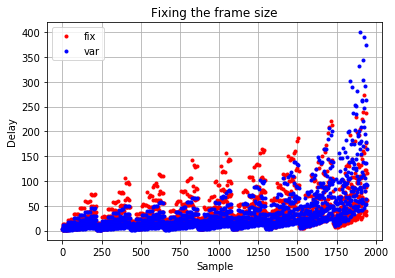

In [7]:

plt.figure()
plt.plot(y_fix, '.r', label='fix')
plt.plot(var.loc[:,'delay'].values, '.b', label='var')
plt.xlabel('Sample')
plt.ylabel('Delay')
plt.title('Fixing the frame size')
plt.legend()
plt.grid()

In [8]:
def std(x, y):
    """Standard deviation between simulation model values and our estimates"""
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

## ДЕРЕВО РЕШЕНИЙ

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [10]:
tree = DecisionTreeRegressor(max_depth=18)
tree.fit(x_fix, y_fix);

In [11]:
x_fix_test = fix_test.loc[:,'RHOS': 'PKTSIZE'].values
tree_y_estimate = tree.predict(x_fix_test)

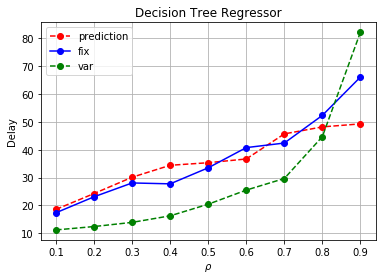

In [12]:
from matplotlib import rc
plt.figure()
plt.plot(fix_test.loc[:,'RHOS'].values, tree_y_estimate, '--or', label='prediction')
plt.plot(fix_test.loc[:,'RHOS'].values, fix_test.loc[:,'delay'].values,'-ob', label='fix')
plt.plot(var_test.loc[:,'RHOS'].values, var_test.loc[:,'delay'].values,'--og', label='var')
plt.xlabel(r'$\rho$')
plt.ylabel('Delay')
plt.title('Decision Tree Regressor')
plt.legend()
plt.grid()

In [13]:
# var values
var_std = std(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)
var_r = np.corrcoef(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)
var_r2 = r2_score(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)

# prediction values
pred_std = std(tree_y_estimate, fix_test.loc[:,'delay'].values)
pred_r = np.corrcoef(tree_y_estimate, fix_test.loc[:,'delay'].values)
pred_r2 = r2_score(fix_test.loc[:,'delay'].values, tree_y_estimate)

data = {'STD':[var_std, pred_std], 'R': [var_r[0,1], pred_r[0,1]], 'R2': [var_r2, pred_r2]}
tree_df = pd.DataFrame(data, index=['VAR', 'PRED'])
tree_df

,STD,R,R2
VAR,13.081706,0.946102,0.669517
PRED,6.911686,0.925434,0.796820


## Градиентный бустинг

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
gb = DecisionTreeRegressor(max_depth=18)
gb.fit(x_fix, y_fix);

In [16]:
x_fix_test = fix_test.loc[:,'RHOS': 'PKTSIZE'].values
gb_y_estimate = tree.predict(x_fix_test)

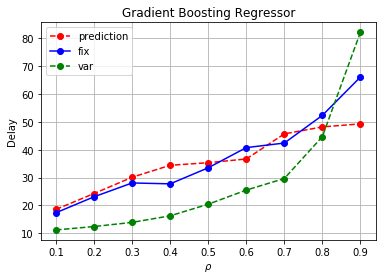

In [17]:
plt.figure()
plt.plot(fix_test.loc[:,'RHOS'].values, gb_y_estimate, '--or', label='prediction')
plt.plot(fix_test.loc[:,'RHOS'].values,fix_test.loc[:,'delay'].values,'-ob', label='fix')
plt.plot(var_test.loc[:,'RHOS'].values, var_test.loc[:,'delay'].values,'--og', label='var')

plt.xlabel(r'$\rho$')
plt.ylabel('Delay')
plt.title('Gradient Boosting Regressor')
plt.legend()
plt.grid()


In [18]:
# var values
var_std = std(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)
var_r = np.corrcoef(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)
var_r2 = r2_score(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)

# prediction values
pred_std = std(gb_y_estimate, fix_test.loc[:,'delay'].values)
pred_r = np.corrcoef(gb_y_estimate, fix_test.loc[:,'delay'].values)
pred_r2 = r2_score(fix_test.loc[:,'delay'].values, gb_y_estimate)

data = {'STD':[var_std, pred_std], 'R': [var_r[0,1], pred_r[0,1]], 'R2': [var_r2, pred_r2]}
tree_df = pd.DataFrame(data, index=['VAR', 'PRED'])
tree_df

,STD,R,R2
VAR,13.081706,0.946102,0.669517
PRED,6.911686,0.925434,0.796820


## Искусственные нейроные сети

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers

**Нормализация входных тренировочных и тестовых данных**

Для лучшей сходимости данных необходимо привести данные к одному диапазону.

In [20]:
def normalize(table, stat):
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose())/ stat.loc['std',:].transpose()

***Тренирочные данные:***

In [21]:
fix_normalize = normalize(fix.loc[:,'RHOS': 'PKTSIZE'], fix.loc[:,'RHOS': 'PKTSIZE'].describe())
x_train = fix_normalize.loc[:,'RHOS': 'PKTSIZE'].values
y_train = fix.loc[:,'delay'].values

***Тестовые данные:***

In [22]:
fix_test_normalize = normalize(fix_test.loc[:,'RHOS': 'PKTSIZE'], fix.loc[:,'RHOS': 'PKTSIZE'].describe())
x_test = fix_test_normalize.loc[:,'RHOS': 'PKTSIZE'].values
y_test = fix_test.loc[:,'delay'].values

Построим **модель сети**

Нейронная сеть будет иметь один скрытый слой с сигмоидальной функцией активации. В качестве метода оптимизации был выбран алгоритм **Адама**.

In [29]:
def build_model():
    model = keras.Sequential([
        # Input Layer
        layers.Dense(25, activation='relu', use_bias=True, input_shape=[len(fix_test_normalize.loc[:,'RHOS': 'PKTSIZE'].keys())]),
        # Hidden Layer
        layers.Dense(25, activation='sigmoid', use_bias=True,),
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [24]:
model = build_model()

In [25]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
EPOCHS = 1000
keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, epochs=EPOCHS, 
                    validation_split = 0.2, verbose=0, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

In [26]:
ann_y_estimate = model.predict(x_test).flatten()


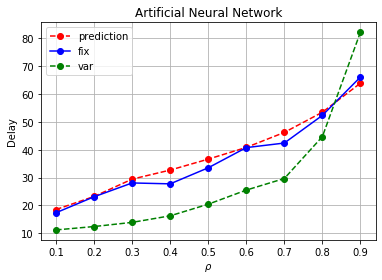

In [27]:
plt.figure()
plt.plot(fix_test.loc[:,'RHOS'].values, ann_y_estimate, '--or', label='prediction')
plt.plot(fix_test.loc[:,'RHOS'].values,fix_test.loc[:,'delay'].values,'-ob', label='fix')
plt.plot(var_test.loc[:,'RHOS'].values, var_test.loc[:,'delay'].values,'--og', label='var')

plt.xlabel(r'$\rho$')
plt.ylabel('Delay')
plt.title('Artificial Neural Network')
plt.legend()
plt.grid()

In [28]:
# var values
var_std = std(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)
var_r = np.corrcoef(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)
var_r2 = r2_score(var_test.loc[:,'delay'].values, fix_test.loc[:,'delay'].values)

# prediction values
pred_std = std(ann_y_estimate, fix_test.loc[:,'delay'].values)
pred_r = np.corrcoef(ann_y_estimate, fix_test.loc[:,'delay'].values)
pred_r2 = r2_score(fix_test.loc[:,'delay'].values, ann_y_estimate)

data = {'STD':[var_std, pred_std], 'R': [var_r[0,1], pred_r[0,1]], 'R2': [var_r2, pred_r2]}
ann_df = pd.DataFrame(data, index=['VAR', 'PRED'])
ann_df

,STD,R,R2
VAR,13.081706,0.946102,0.669517
PRED,2.693152,0.990882,0.969151
